In [1]:
import sys 
sys.path.append('../')

import torch
import matplotlib.pyplot as plt 
from einops import repeat

from src.green_net import GreenNet2D
from src.model import MLP
from src.utils import rl2_error
from src.dataset import load_mat2d

In [2]:
def DiskPoisson(pts):
    x1 = pts[...,0]
    y1 = pts[...,1]
    x2 = pts[...,2]
    y2 = pts[...,3]

    mask = ((x1**2+y1**2) < 1) & ((x2**2+y2**2) < 1)

    k = 1/(4*torch.pi) * torch.log(
        ((x1 - x2)**2 + (y1-y2)**2) / \
        ((x1*y2-x2*y1)**2 + (x1*x2+y1*y2-1)**2))
    k = torch.nan_to_num(k, neginf=-1) * mask

    return k

In [3]:
def DiskInvdist(pts):
    x1 = pts[...,0]
    y1 = pts[...,1]
    x2 = pts[...,2]
    y2 = pts[...,3]

    mask = ((x1**2+y1**2) < 1) & ((x2**2+y2**2) < 1)

    k = ((x1 - x2)**2 + (y1-y2)**2) ** (-0.5)
    k = torch.nan_to_num(k, posinf=55) * mask

    return k

In [4]:
def ffunc_2D(pts):
    x = pts[:,0]
    y = pts[:,1]
    u = 1 - (x**2+y**2)
    u = torch.nan_to_num(u, posinf=0)
    return u

In [5]:
device = torch.device('cpu')
# kernel = MLP([2, 64, 1], nonlinearity='relu').to(device)
model = GreenNet2D(n=6, kernel=DiskPoisson, device=device, sub_num=5)
# model = GreenNet2D(n=6, kernel=DiskInvdist, device=device, sub_num=5)

In [6]:
F = load_mat2d('../dataset/fdisk_65x65_2.00e-01.mat', 'F', 100)
U_ref = load_mat2d('../dataset/poisson_65x65_2.00e-01.mat', 'U', 100)

F = torch.from_numpy(F).reshape(100,-1)
U_ref = torch.from_numpy(U_ref).reshape(100,-1)
# U_ref = load_mat2d('../dataset/poisson_65x65_2.00e-01.mat', 'U', 100)

In [7]:
model.eval_K()
U_full = model.full_kint(F)

In [8]:
rl2_error(U_full, U_ref)

tensor(1.0322e-08)

In [9]:
# F = ffunc_2D(model.grid.x_h)
# F = repeat(F, 'n -> b n', b=64)

Ground Truth Kernel Function

In [10]:
model.eval_K()
nh = model.grid.nh
K_full = model.K_hh.reshape(nh,nh,nh,nh)

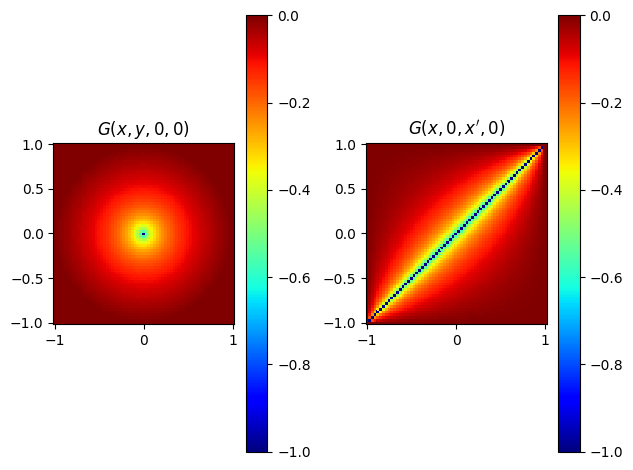

In [11]:
xy = model.grid.x_h.reshape(nh,nh,2)
mask = (xy[...,0]**2 + xy[...,1]**2) > 1
G_xy00 = K_full[:,:,32,32]
# G_xy00[mask] = torch.nan
G_x0y0 = K_full[:,32,:,32]
plt.subplot(121)
plt.pcolor(xy[...,0], xy[...,1], G_xy00, cmap='jet')
plt.title('$G(x,y,0,0)$')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(122)
plt.pcolor(xy[...,0], xy[...,1], G_x0y0, cmap='jet')
plt.title('$G(x,0,x\',0)$')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.tight_layout()

Full Kernel Integral

In [12]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> b n', b=64)
U_full = model.full_kint(F)
f = F[0].reshape(nh,nh)
u = U_full[0].reshape(nh,nh)
f[mask] = torch.nan 
u[mask] = torch.nan

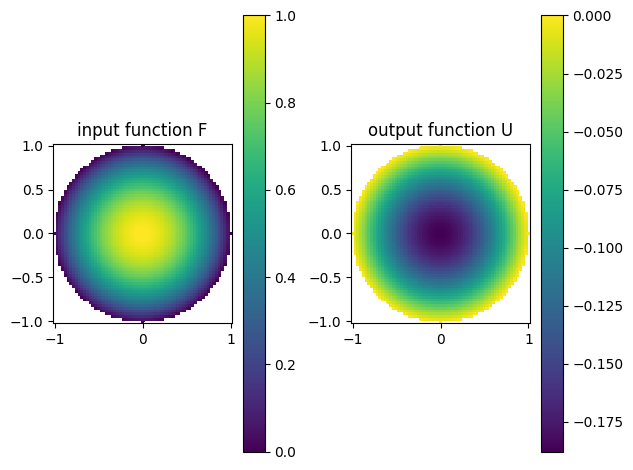

In [13]:
plt.subplot(121)
plt.pcolor(xy[...,0], xy[...,1], f)
plt.title('input function F')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(122)
plt.pcolor(xy[...,0], xy[...,1], u)
plt.title('output function U')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.tight_layout()

Test Eval Batch

In [14]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> b n', b=64) 
model.rand_sub()
print('random sub : ', model.sub)
model.eval_K_sub()
U_sub = model.sub_kint(F)

random sub :  tensor([3102, 3240, 3603, 3175, 1163])


In [15]:
U_full[:,model.sub][0]

tensor([-0.0899, -0.0278, -0.0723, -0.0327, -0.0160])

In [16]:
U_sub[0]

tensor([-0.0899, -0.0278, -0.0723, -0.0327, -0.0160])

Test Batch Kint

In [17]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> b n', b=64)
model.eval_K()
U_full = model.full_kint(F)
U_batch = model.evalint_batch(F)  


In [18]:
print('U rl2 : ' , rl2_error(U_batch, U_full))

U rl2 :  tensor(1.2836e-07)
